# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [5]:
#импорт библиотек
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

## Загрузка и подготовка данных

In [6]:
#загружаем данные с георазведками трех регионов
try:
    reg_0 = pd.read_csv('geo_data_0.csv')
    reg_1 = pd.read_csv('geo_data_1.csv')
    reg_2 = pd.read_csv('geo_data_2.csv')
except FileNotFoundError as e:
    print(repr(e))
    reg_0 = pd.read_csv('/datasets/geo_data_0.csv')
    reg_1 = pd.read_csv('/datasets/geo_data_1.csv')
    reg_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [7]:
#напишем функцию которая будет выводить базовую информацию по датафреймам трех регионов
def data_check(df):
    print('')
    print(df.info())
    print(df.head())
    print(df.describe())
    print('Кол-во дубликатов:',df.duplicated().sum())
    print()
    print()
    df.hist(figsize=(9,9))
    plt.show()

In [8]:
#запишем регионы в лист чтобы пройтись по ним циклом
regions_data=[reg_0,reg_1,reg_2]

Регион 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248

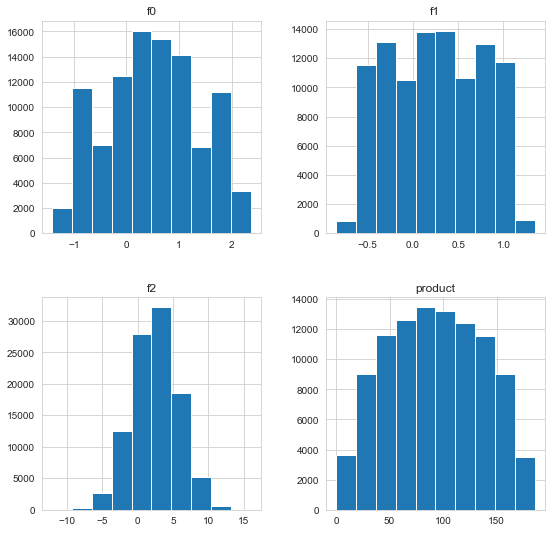

Регион 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872

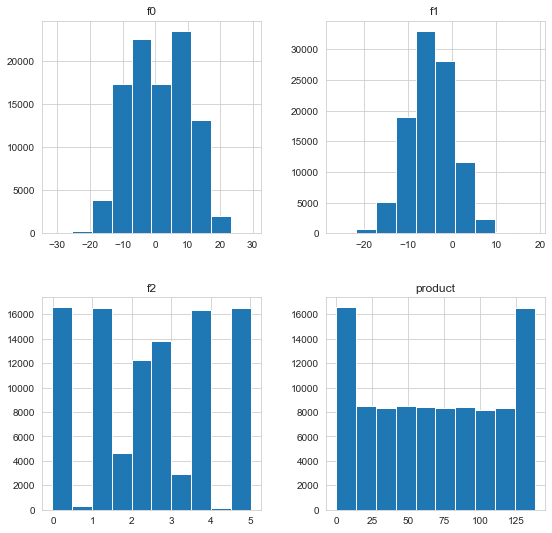

Регион 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473

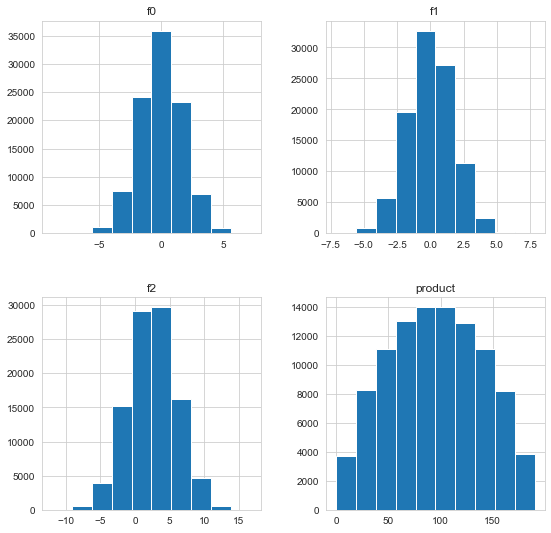

In [9]:
n=0
for i in regions_data:
    print('Регион',n)
    data_check(i)
    n+=1

Вывод: Данные в порядке, типы данных соответствуют величинам, пропуски и дубликаты отсутствуют.
В регионе_1 отличающиеся от других распределение параметра f2 и очень равномерное распределение добычи по скаважинам региона, при этом в регионе есть две небольшие под-области с очень высокими и очень низкими запасами.


Для дальнейшей работы с алгоритмами ML нам не потребуется признак 'id'.
Удалим его:

In [13]:
reg_0 = reg_0.drop('id',axis=1)
reg_1 = reg_1.drop('id',axis=1)
reg_2 = reg_2.drop('id',axis=1)

Разобьем данные трех регионов на train и valid в соотношении 75:25.
Далее эти данные разобьем на Y(целевой признак - 'product' или объем запасов в скважине) и X признаки (f0,f1,f2)

## Обучение и проверка модели

In [14]:
from sklearn.pipeline import  make_pipeline

In [15]:
def region_model_train(r):
    X_train, X_valid, y_train, y_valid = train_test_split(r.drop('product',axis=1), r['product'], test_size=0.25, random_state=2022) #разбиваем на train и valid
    pipe = make_pipeline(StandardScaler(), LinearRegression()) # создадим пайп из StandardScaler и LR
    pipe.fit(X_train, y_train)  # обучаем на train выборке
    predict = pipe.predict(X_valid)  # делаем предсказания по valid признакам
    print("Средний запас сырья скважины (предсказанный):", predict.mean())
    print("RMSE модели", mean_squared_error(y_valid, predict, squared=False) )

    return pipe, X_valid, y_valid, predict

In [16]:
print('Регион_0')
model_r0, r0_valid_x, r0_valid_y, r0_y_predict = region_model_train(reg_0)

Регион_0
Средний запас сырья скважины (предсказанный): 92.27940812035393
RMSE модели 37.71605325398609


In [35]:
r0_y_predict

array([116.04720614,  40.62660021,  92.17277165, ..., 120.91409286,
        95.42458983,  97.4448408 ])

In [34]:
r0_valid_y

59286     97.073741
71695     22.801890
70788    159.562003
48299     76.784079
16144     16.736364
            ...    
15622    170.076702
2825      75.109301
513      160.019337
13971     88.899014
58687    104.340855
Name: product, Length: 25000, dtype: float64

In [42]:
a = np.stack((r0_valid_y,r0_y_predict),axis=-1)
idx =  np.argsort(a[:,1])

In [43]:
a[idx,:]

array([[  1.54788573,  -2.70845377],
       [  4.43163909,   2.4747658 ],
       [ 11.01869165,   4.54666248],
       ...,
       [164.82127804, 173.31505047],
       [145.10689342, 174.04833583],
       [ 96.89358065, 175.95931102]])

In [44]:
a[:,0][idx][-10:]

array([182.04367351, 183.37192128, 152.89833652, 117.50847081,
       184.66057615, 146.85998915, 130.98568123, 164.82127804,
       145.10689342,  96.89358065])

In [17]:
print('Регион_1')
model_r1, r1_valid_x, r1_valid_y, r1_y_predict = region_model_train(reg_1)

Регион_1
Средний запас сырья скважины (предсказанный): 68.95875841289144
RMSE модели 0.8868593841814516


In [18]:
print('Регион_2')
model_r2, r2_valid_x, r2_valid_y, r2_y_predict = region_model_train(reg_2)

Регион_2
Средний запас сырья скважины (предсказанный): 94.96963599907178
RMSE модели 39.79701468825408


Вывод: Самые точные предсказания получилось сделать для Региона - 1 (RMSE  меньше единицы), но при этом в регионе самый низкий запас сырья на скважину если брать среднее.

Регионы 0 и 2 в целом похожи. У Региона 2 немного выше средний предсказанный запас сырья но при этом на ту же величину выше ошибка RMSE.


## Подготовка к расчёту прибыли

In [19]:
#обозначим переменные для расчета прибыли
COST = 10**10 #бюджет 10 млрд. рублей
REVENUE_PER_PRODUCT = 450000 #выручка c продажи 1 тысячи баррелей
NUM_WELLS_DEPLOY = 200 # количество скважин для разработки
NUM_WELLS_DISCOVERY = 500 # количество скважин для исследования

In [20]:
#найдем количество тысяч баррелей при продажи которых разработка полностью окупается
req_product = COST / REVENUE_PER_PRODUCT
print('Необходимые суммарные запасы скважин для покрытия расходов на разведку', req_product)

Необходимые суммарные запасы скважин для покрытия расходов на разведку 22222.222222222223


In [21]:
#найдем необходимый запас в тысячах баррелей на одну скважину, чтобы понять сколько в среднем должно быть запасов в скважине для безубыточного вложения в разведку 200 скважин
product_per_well = req_product / NUM_WELLS_DEPLOY
print('Необходимый средний запас в скважине для покрытия расходов на разведку',product_per_well)

Необходимый средний запас в скважине для покрытия расходов на разведку 111.11111111111111


Для безубыточной разработки средний запас скважины должен быть выше 111.1 тысяч баррелей.
Что превышает средний запас скважин во всех трех регионов.

## Расчёт прибыли и рисков

В данном разделе будем симулировать выбор скважин по данным разведки (получены признаки f0,f1,f2) с помощью  модели которую мы обучили, и считать какую прибыль мы бы получили по факту при таком выборе.

Иными словами, будем выбирать скважины используя ML, а проверять себя будем используя реальные данные по запасам на основе которых рассчитаем прибыль (для выбранных нами скважин).


In [45]:
#напишем функцию расчета прибыли в млн.руб
#в качестве параметров функции: предсказания по добыче (тыс баррелей), истинная добыча (тыс баррелей), кол-во скважин, выручка с тыс. баррелей, бюджет на разработку)

def profit(y_predict, y_true, count, revenue_per_product, cost):

    y = np.stack((y_true,y_predict),axis=-1) #объединим в один массив предсказания и добычу
    idx =  np.argsort(y[:,1]) #отсортируем данные предсказаний по добыче

    #среди истинных значений добычи выберем те скважины (в количестве  count), которые попали в топ-"count" по добыче на основе предсказанных данных  (используя индексы)

    true_selected=y[:,0][idx][-count:]
    #по выбранным скважинам рассчитаем выручку в млрд рублей на основе реальной добычи

    return (sum(true_selected*revenue_per_product)-cost)/10**6




Для начала рассмотрим ситуацию в которой будто бы нам известны признаки всех 25000 скважин (которые у нас есть в валидационной выборке).
Для этих 25000 у нас уже есть предсказания по добыче. Из 25000 мы выберем 200 лучших скважин (по предсказаниям добычи) и посчитаем какая бы у нас оказалась прибыль если бы именно эти 200 скважин разработали.

Выручка Региона_0:

In [46]:
profit(r0_y_predict,r0_valid_y,NUM_WELLS_DEPLOY,REVENUE_PER_PRODUCT, COST)

3268.8887239093665

Выручка Региона_1:

In [48]:
profit(r1_y_predict,r1_valid_y,NUM_WELLS_DEPLOY,REVENUE_PER_PRODUCT, COST)

2415.0866966815624

Выручка Региона_2

In [49]:
profit(r2_y_predict,r2_valid_y,NUM_WELLS_DEPLOY,REVENUE_PER_PRODUCT, COST)

2498.8484288057175

Вывод: Здорово, выручка по всем трём регионам почти 2.5 млрд рублей, получается наши модели работают, ведь в среднем каждая из скважин этих трех регионов ниже по запасам чем целевое значение 111.1 баррелей.

Но реальная жизнь сурова, и по факту разведать мы можем не 25000 скважин, а только 500. Поэтому будем имитировать ситуацию когда мы выбираем 500 случайных точек в регионе, получаем для них данные их исследования(каротаж), в виде признаков, делаем предсказания по добыче, выбираем 200 лучших и смотрим какую прибыль мы бы получили сделав такой выбор.

Провернем такую симуляцию 1000 раз (техника bootstrap)

In [54]:
#напишем bootstrap функцию которая на вход будет принимать валидационные признаки(x) и валидационный таргет(y), кол-во итераций, и модель ML
def bootstrap_profit(y,x,iter,mod):
    revenue_list=[]
    state = np.random.RandomState(2022)
    for i in range(0,iter): #делаем цикл на симуляцию расчета прибыли по топ200 из 500 случайных
        #выбираем 500 случайных скважин из валид. выборки
        sample_y = y.sample(NUM_WELLS_DISCOVERY, random_state=state) #выбираем 500 случайных таргетов
        sample_x = x.loc[sample_y.index] #выбираем соответствующие выбранным таргетам признаки
        sample_y.reset_index(drop=True, inplace=True) #делаем ресет индекса для корректной работы функии revenue
        predict = mod.predict(sample_x) #делаем предсказания
        #отправляем целевой признак, предсказания и прочие параметры для расчета прибыли
        #записываем прибыль итерации в список
        revenue_list.append(profit(predict, sample_y,NUM_WELLS_DEPLOY,REVENUE_PER_PRODUCT, COST))

    revenue_list = pd.Series(revenue_list) #преобразуем список в Series для дальнейшей работы с ним
    return revenue_list


Запишем результаты bootstrap для трех регионов в три соответствующие переменные:
reg_0_revenue
reg_1_revenue
reg_2_revenue

In [55]:
reg_0_revenue = bootstrap_profit(r0_valid_y,r0_valid_x,1000, model_r0)

In [56]:
reg_1_revenue = bootstrap_profit(r1_valid_y,r1_valid_x,1000, model_r1)

In [57]:
reg_2_revenue = bootstrap_profit(r2_valid_y,r2_valid_x,1000, model_r2)

Напишем функцию для анализа прибыли региона которая на вход будет принимать массив значений прибыли итераций bootstrap, а на выходе выдавать интересующие нас параметры региона:
* Средняя выручка
* 95% доверительный интервал
* Риск убытков

In [58]:
def profit_analysis(profit_array):
    low=profit_array.quantile(0.025) #найдем нижнюю границу доверительного диапазона
    high=profit_array.quantile(0.975) #найдем верхнюю границу доверительного диапазона
    print('Средняя выручка в итерациях bootstrap:', profit_array.mean())
    print('95% доверительный интервал прибыли:','(', low,',',high,')')
    neg_profit=profit_array.loc[profit_array < 0].max() #найдем значение максимальной отрицательной выручки
    risk = stats.percentileofscore(profit_array,neg_profit) #посчитаем для этого значения его персентиль
    print('Риск убытков',risk)

Анализ Региона_0:

In [59]:
profit_analysis(reg_0_revenue)

Средняя выручка в итерациях bootstrap: 381.7344312340613
95% доверительный интервал прибыли: ( -127.46769449789552 , 888.8094875103241 )
Риск убытков 6.4


Анализ Региона_1:

In [60]:
profit_analysis(reg_1_revenue)

Средняя выручка в итерациях bootstrap: 468.0270328452864
95% доверительный интервал прибыли: ( 46.74874471915121 , 876.6080336317467 )
Риск убытков 1.4


Анализ Региона_2

In [61]:
profit_analysis(reg_2_revenue)

Средняя выручка в итерациях bootstrap: 365.8259743948694
95% доверительный интервал прибыли: ( -146.2383501473024 , 874.1446451395058 )
Риск убытков 8.4


К сожалению, риск убытков ниже целевых 2.5% только для Региона_1, для которого у нас получилась супер-точная модель ML. Несмотря на то, что в данном регионе в среднем запасы скважины значительно ниже целевых 111.1, при выборе используя модель с вероятностью в 98.6% можно получить прибыль.

К добыче рекомендован Регион_1.

Хотя, конечно, очевидно, что имея немного более точную модель предсказаний добычи для Регионов 0 и 2, мы бы сделали другой вывод


## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован